#Notebook for link prediciton analysis
##Coursework 2015, HSE - DataSci
###Sergey Korolev

####First attempt, similarity based algorithms

####Networks used:
1. UciNet data - http://vlado.fmf.uni-lj.si/pub/networks/data/UciNet/UciData.htm
2. Pajek datasets - http://vlado.fmf.uni-lj.si/pub/networks/data/default.htm
3. ND - http://www3.nd.edu/~networks/resources.htm (possibly already in pajek ds)
4. Alex Arenas - http://deim.urv.cat/~alexandre.arenas/data/welcome.htm
5. Stanford nets - http://snap.stanford.edu/data/

Really hope to sift through them or just write some interface to load them into networkx to work with them.

#####All theoretical notes on the algroithms are quoted directly from Linyuan Lü, Tao Zhou, Link prediction in complex networks: A survey, Physica A 390, 2011

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import operator
import pandas as pd
%matplotlib inline

In [3]:
G = nx.karate_club_graph()

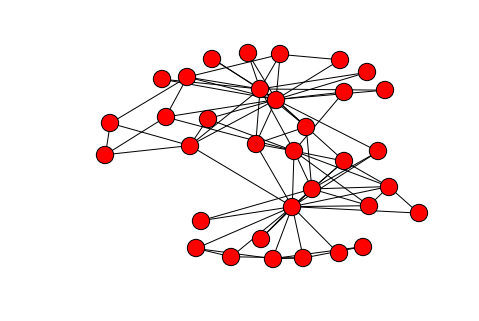

In [3]:
pos = nx.spring_layout(G)
nx.draw(G, pos)

In [6]:
def chunk(xs, n):
    ys = list(xs)
    random.shuffle(ys)
    size = len(ys) // n
    leftovers= ys[size*n:]
    for c in xrange(n):
        if leftovers:
           extra= [ leftovers.pop() ] 
        else:
           extra= []
        yield ys[c*size:(c+1)*size] + extra

####Common neighbours
For a node x, let $\Gamma(x)$ denote the set of neighbors of $x$. In common sense, two nodes, $x$ and $y$, are more likely to have a link if they have many common neighbors. The simplest measure of this neighborhood overlap is the directed count, namely
$$s_{xy}^{CN} = |\Gamma(x) \cap \Gamma(y)|,$$
where $|Q|$ is the cardinality of the set $Q$. It is obvious that $s_{xy} = (A^2)_{xy}$, where $A$ is the adjacency matrix: $A_{xy} = 1$ if $x$ and $y$ are directly connected and $A_{xy} = 0$ otherwise. Note that, $(A^2)_{xy}$ is also the number of different paths with length 2 connecting $x$ and $y$. Newman [40] used this quantity in the study of collaboration networks, showing a positive correlation between the number of common neighbors and the probability that two scientists will collaborate in the future. Kossinets and Watts [14] analyzed a large-scale social network, suggesting that two students having many mutual friends are very probable to be friends in future. The following six indices are also based on the number of common neighbors, yet with different normalization methods.

In [7]:
folds = [i for i in chunk(G.edges(), 10)]

In [8]:
subs = []
for i in xrange(10):
    graph = G.copy()
    for c in folds[i]:
        graph.remove_edge(*c)
    subs.append(graph.copy())

In [7]:
def common_neighbours(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = mat[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Salton Index
It is defined as
$$s_{xy}^{Salton} = \frac{|\Gamma(x) \cap \Gamma(y)|}{\sqrt{k_x \times k_x}}$$
where $k_x$ is the degree of node $x$. The Salton index is also called the cosine similarity in the literature.

In [8]:
def salton_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 and k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(np.sqrt(j * k))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Jaccard Index
This index was proposed by Jaccard over a hundred years ago, and is defined as
$$s_{xy}^{Jaccard} = \frac{|\Gamma(x) \cap \Gamma(y)|}{|\Gamma(x) \cup \Gamma(y)|}$$

In [9]:
def jaccard_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            if nx.degree(i, e[0]) != 0 or nx.degree(i, e[1]) != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(len(set(i[e[0]])|set(i[e[1]])))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Sorensen Index
This index is used mainly for ecological community data, and is defined as
$$s_{xy}^{Sorensen} = \frac{2|\Gamma(x) \cap \Gamma(y)|}{k_x + k_y}$$

In [10]:
def sorensen_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 or k != 0:
                edgesWithScore[e] = 2*float(mat[e[0]][e[1]])/float(j + k)
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Hub Promoted Index (HPI)
This index is proposed for quantifying the topological overlap of pairs of substrates in metabolic networks, and is defined as
$$s_{xy}^{HPI} = \frac{|\Gamma(x) \cap \Gamma(y)|}{min\{k_x, k_y\}}$$
Under this measurement, the links adjacent to hubs are likely to be assigned high scores since the denominator is determined by the lower degree only.

In [11]:
def hub_promoted_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 and k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(min(j, k))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Hub Depressed Index (HDI)
Analogously to the above index, we also consider a measurement with the opposite effect on hubs, defined as
$$s_{xy}^{HDI} = \frac{|\Gamma(x) \cap \Gamma(y)|}{max\{k_x, k_y\}}$$

In [12]:
def hub_depressed_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 or k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(max(j, k))
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Leicht–Holme–Newman Index (LHN1)
This index assigns high similarity to node pairs that have many common neighbors compared not to the possible maximum, but to the expected number of such neighbors. It is defined as
$$s_{xy}^{LHN1} = \frac{|\Gamma(x) \cap \Gamma(y)|}{k_x \times k_y}$$
where the denominator, $k_x \times k_y$, is proportional to the expected number of common neighbors of nodes $x$ and $y$ in the configuration model. We use the abbreviation LHN1 to distinguish this index to another index (named as LHN2 index) also proposed by Leicht, Holme and Newman.

In [13]:
def LHN1_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1).dot(np.array((nx.to_numpy_matrix(i) != 0) * 1))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            j = nx.degree(i, e[0])
            k = nx.degree(i, e[1])
            if j != 0 and k != 0:
                edgesWithScore[e] = float(mat[e[0]][e[1]])/float(j * k)
            else:
                edgesWithScore[e] = 0
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Preferential Attachment Index (PA)
The mechanism of preferential attachment can be used to generate evolving scale- free networks, where the probability that a new link is connected to the node $x$ is proportional to $k_x$. A similar mechanism can also lead to scale-free networks without growth, where at each time step, an old link is removed and a new link is generated. The probability that this new link will connect $x$ and $y$ is proportional to $k_x \times k_y$. Motivated by this mechanism, the corresponding similarity index can be defined as
$$s_{xy}^{PA} = k_x \times k_y$$
which has been widely used to quantify the functional significance of links subject to various network-based dynamics, such as percolation, synchronization and transportation. Note that, this index does not require the information of the neighborhood of each node, as a consequence, it has the least computational complexity.

In [14]:
def preferential_attachment_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = nx.degree(i, e[0]) * nx.degree(i, e[1])
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

####Adamic–Adar Index (AA)
This index refines the simple counting of common neighbors by assigning the less- connected neighbors more weights, and is defined as
$$s_{xy}^{AA} = \sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{log k_z}$$

In [15]:
def adamic_adar_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = np.sum(1/np.log(nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()))
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1
        
    return np.mean(auc)

####Resource Allocation Index (RA)
This index is motivated by the resource allocation dynamics on complex networks. Consider a pair of nodes, $x$ and $y$, which are not directly connected. The node $x$ can send some resource to $y$, with their common neighbors playing the role of transmitters. In the simplest case, we assume that each transmitter has a unit of resource, and will equally distribute it to all its neighbors. The similarity between $x$ and $y$ can be defined as the amount of resource $y$ received from $x$, which is
$$s_{xy}^{RA} = \sum_{z \in \Gamma(x) \cap \Gamma(y)} \frac{1}{k_z}$$
Clearly,this measure is symmetric,namely $s_{xy} = s_{yx}$.Note that, although resulting from different motivations, the AA index and RA index have very similar form. Indeed, they both depress the contribution of the high-degree common neighbors. AA index takes the form $(log k )^{−1}$ while RA index takes the form $k^{−1}$. The difference is insignificant when the degree, $k_z$, is small, while it is considerable when $k_z$ is large. In other words, RA index punishes the high-degree common neighbors more heavily than AA.

In [16]:
def resourse_allocation_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = np.sum(1/np.array(
                    nx.degree(i, sorted(nx.common_neighbors(i, e[0], e[1]))).values()).astype(float))
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1
        
    return np.mean(auc)

In [17]:
def run_local_similarity_indices(G, symmetric = True, nfolds = 10, seed = 0):
    random.seed(seed)
    folds = [i for i in chunk(G.edges(), nfolds)]
    subs = []
    for i in xrange(nfolds):
        graph = G.copy()
        for c in folds[i]:
            graph.remove_edge(*c)
        subs.append(graph.copy())
    cn = common_neighbours(folds, subs, symmetric = symmetric)
    print 'cn'
    sai = salton_index(folds, subs, symmetric = symmetric)
    print 'sai'
    ji = jaccard_index(folds, subs, symmetric = symmetric)
    print 'ji'
    soi = sorensen_index(folds, subs, symmetric = symmetric)
    print 'soi'
    hpi = hub_promoted_index(folds, subs, symmetric = symmetric)
    print 'hpi'
    hdi = hub_depressed_index(folds, subs, symmetric = symmetric)
    print 'hdi'
    lhn1 = LHN1_index(folds, subs, symmetric = symmetric)
    print 'LHN1'
    pai = preferential_attachment_index(folds, subs, symmetric = symmetric)
    print 'pai'
    aai = adamic_adar_index(folds, subs, symmetric = symmetric)
    print 'aai'
    rai = resourse_allocation_index(folds, subs, symmetric = symmetric)
    print 'rai'
    aucs = {'CN' : cn, 
            'SaI' : sai, 
            'JI' : ji, 
            'SoI' : soi,
            'HPI' : hpi,
            'HDI' : hdi,
            'LHN1' : lhn1,
            'PAI' : pai,
            'AAI' : aai,
            'RAI' : rai}
    return aucs

In [18]:
df = pd.DataFrame(columns = ['CN', 'SaI', 'JI', 'SoI', 'HPI', 'HDI', 'LHN1', 'PAI', 'AAI', 'RAI'])

In [19]:
df.loc['karate club'] = run_local_similarity_indices(nx.karate_club_graph())

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [20]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396


In [21]:
pajek_football = nx.read_pajek('./netws/pajekds/football.net')

In [22]:
fixed_pajek_football = nx.Graph(nx.convert_node_labels_to_integers(pajek_football, first_label = 0))

In [23]:
df.loc['pajek football'] = run_local_similarity_indices(fixed_pajek_football)

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [24]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek football,0.662064,0.588845,0.587198,0.587198,0.600118,0.578401,0.490883,0.754943,0.658615,0.652655


In [25]:
pajek_us_air = nx.read_pajek('./netws/pajekds/USAir97.net')

In [26]:
fixed_pajek_us_air = nx.Graph(nx.convert_node_labels_to_integers(pajek_us_air, first_label = 0))
pajek_us_air = 0

In [27]:
df.loc['pajek_us_air'] = run_local_similarity_indices(fixed_pajek_us_air)

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [28]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek football,0.662064,0.588845,0.587198,0.587198,0.600118,0.578401,0.490883,0.754943,0.658615,0.652655
pajek_us_air,0.934896,0.908560,0.898030,0.898030,0.870076,0.891644,0.767659,0.886947,0.945853,0.951752


In [31]:
pajek_netscience = nx.read_pajek('./netws/pajekds/netsience.net')

In [32]:
fixed_pajek_netscience = nx.Graph(nx.convert_node_labels_to_integers(pajek_netscience, first_label = 0))
pajek_netscience = 0
df.loc['pajek netscience'] = run_local_similarity_indices(fixed_pajek_netscience)
fixed_pajek_netscience = 0

cn
sai
ji
soi
hpi
hdi
LHN1
pai
aai
rai


In [34]:
df

,CN,SaI,JI,SoI,HPI,HDI,LHN1,PAI,AAI,RAI
karate club,0.699908,0.636143,0.606829,0.606829,0.712276,0.592641,0.599922,0.711626,0.725595,0.733396
pajek football,0.662064,0.588845,0.587198,0.587198,0.600118,0.578401,0.490883,0.754943,0.658615,0.652655
pajek_us_air,0.934896,0.908560,0.898030,0.898030,0.870076,0.891644,0.767659,0.886947,0.945853,0.951752
pajek netscience,0.940165,0.940314,0.940269,0.940269,0.940200,0.940221,0.939941,0.679141,0.940459,0.940473


In [35]:
df.to_csv('first_four.csv')

###Global similarity indices

####1. Katz Index
This index is based on the ensemble of all paths, which directly sums over the collection of paths
and is exponentially damped by length to give the shorter paths more weights. The mathematical expression reads
$$S^{Katz} = (I - \beta A)^{-1} - I.$$
Note that, β must be lower than the reciprocal of the largest eigenvalue of matrix A to ensure the convergence of Eq.

In [49]:
def katz_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        ide = np.identity(len(mat))
        beta = (1/float(max(np.linalg.eig(mat)[0])))/2
        sim = np.linalg.inv(ide - beta*mat) - ide
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [50]:
katz_index(folds, subs)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: ComplexWarning: Casting complex values to real discards the imaginary part


0.75227373558118893

####2. Leicht–Holme–Newman Index (LHN2)
This index is a variant of the Katz index. Based on the concept that two
nodes are similar if their immediate neighbors are themselves similar, one obtains a self-consistent matrix formulation
$$S^{LHN2} = 2 m \lambda_1 D^{-1} (I - \frac{\phi A}{\lambda_1})^{-1} D^{-1},$$
where $\lambda_1$ is the largest eigenvalue of $A$, $m$ is the total number of edges in the network and $D$ is the degree matrix with $D_{xy} = \delta_{xy}k_x$ and $\phi (0 < \phi < 1)$ is a free parameter. The choosing of $\phi$ depends on the investigated network, and smaller $\phi$ assigns more weights on shorter paths.

In [52]:
def lhn2_index(folds, subs, phi = 0.5, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        ide = np.identity(len(mat))
        dma = np.diagflat(mat.sum(axis = 1))
        if np.linalg.det(dma) != 0:
            lambd = float(max(np.linalg.eig(mat)[0]))
            sim = (2 * i.number_of_edges() * lambd * np.linalg.inv(dma)).dot(np.linalg.inv(
            ide - (phi/lambd) * mat)).dot(np.linalg.inv(dma))
            edgesWithScore = {}
            edges = nx.non_edges(i)
            for e in edges:
                edgesWithScore[e] = sim[e[0]][e[1]]
            highScore = 0
            sameScore = 0
            allScore = 0
            for e in edgesWithScore:
                if e not in folds[step]:
                    for s in folds[step]:
                        if edgesWithScore[e] < edgesWithScore[s]:
                            highScore += 1
                        elif edgesWithScore[e] == edgesWithScore[s]:
                            sameScore += 1
                        allScore += 1
            auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [53]:
lhn2_index(folds, subs)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


0.61354300174175946

####3. Average Commute Time (ACT)
Assuming two nodes are more similar if they have a smaller average commute time, then the similarity between the nodes x and y can be defined as the reciprocal of $n(x, y)$, namely (the constant factor M is removed)
$$S_{xy}^{ACT} = \frac{1}{l_{xx}^{+} + l_{yy}^{+} - 2l_{xy}^{+}},$$
where $l_{xy}^{+}$ denotes the corresponding entry in the Laplacian matrix, $L^{+} (L = D − A)$.

In [62]:
def act_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = 1/float(sim[e[0]][e[0]] + sim[e[1]][e[1]] - 2*sim[e[0]][e[1]])
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [63]:
act_index(folds, subs)

0.66710662525879916

####4. Cosine based on $L^{+}$
This index is an inner-product-based measure. In the Euclidean space spanned by $v_x = \Lambda^{\frac{1}{2}} U^{T} e_x,$ where $U$ is an orthonormal matrix made of the eigenvectors of $L^{+}$ ordered in decreasing order of corresponding eigenvalue $\lambda_x, \Lambda = diag(\lambda_x), e_x$ is an $N \times 1$ vector with the $x$th element equal to $1$ and others all equal to $0$, and $T$ is the matrix transposition, the pseudoinverse of the Laplacian matrix are the inner products of the node vectors, $l_{xy}^{+} = v_x^T v_y$. Accordingly, the cosine similarity is defined as the cosine of the node vectors, namely
$$s_{xy}^{cos^{+}} = cos(x, y)^{+} = \frac{v_x^T v_y}{|v_x| \cdot |v_y|} = \frac{l_{xy}^{+}}{\sqrt{l_{xx}^{+} \cdot l_{yy}^{+}}}.$$

In [64]:
def cbl_index(folds, subs, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        sim = np.linalg.pinv(dma - mat)
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = float(sim[e[0]][e[1]])/np.sqrt(sim[e[0]][e[0]] * sim[e[1]][e[1]])
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [65]:
cbl_index(folds, subs)

0.72574682046731742

####5. Random Walk with Restart (RWR)
This index is a direct application of the PageRank algorithm. Consider a random walker starting from node $x$, who will iteratively move to a random neighbor with probability $c$ and return to node $x$ with probability $1 − c$. Denote by $q_{xy}$ the probability this random walker locates at node $y$ in the steady state, we have
$$q_{x} = c P^T q_x + (1 - c) e_x,$$
where $P$ is the transition matrix with $P_{xy} = 1/k_x$ if $x$ and $y$ are connected, and $P_{xy} = 0$ otherwise. The solution is straightforward, as
$$q_x = (1 - c) (I - cP^T)^{-1} e_x.$$
The RWR index is thus defined as
$$s_{xy}^{RWR} = q_{xy} + q_{yx},$$
where $q$ is the $y$th element of the vector $q$.

####6. SimRank
Similar to the LHN2, SimRank is defined in a self-consistent way, according to the assumption that
two nodes are similar if they are connected to similar nodes.
$$s_{xy}^{SimRank} = C \cdot \frac{\sum_{z \in \Gamma(x)} \sum_{z' \in \Gamma(y)} s_{zz'}^{SimRank}}{k_x \cdot k_y},$$
where $s_{xx} = 1$ and $C \in [0, 1]$ is the decay factor. The SimRank can also be interpreted by the random walk process, that is, $s_{xy}^{SimRank}$ measures how soon two random walkers, respectively starting from nodes $x$ and $y$, are expected to meet at a certain node. 

####7. Matrix Forest Index (MFI)
This index is defined as
$$S = (I + L)^{-1},$$
where the similarity between $x$ and $y$ can be understood as the ratio of the number of spanning rooted forests such that nodes $x$ and $y$ belong to the same tree rooted at $x$ to all spanning rooted forests of the network. A parameter-dependent variant of MFI is
$$S = (I + \alpha L)^{-1}, \ \ \ \alpha > 0.$$

In [66]:
def matrix_forest_index(folds, subs, alpha = 1, symmetric = True, nfolds = 10):
    nmis = len(folds[0])
    step = 0
    auc = []
    for i in subs:
        mat = np.array((nx.to_numpy_matrix(i) != 0) * 1.)
        dma = np.diagflat(mat.sum(axis = 1))
        ide = np.identity(len(mat))
        sim = np.linalg.inv(ide + alpha*(dma - mat))
        edgesWithScore = {}
        edges = nx.non_edges(i)
        for e in edges:
            edgesWithScore[e] = sim[e[0]][e[1]]
        highScore = 0
        sameScore = 0
        allScore = 0
        for e in edgesWithScore:
            if e not in folds[step]:
                for s in folds[step]:
                    if edgesWithScore[e] < edgesWithScore[s]:
                        highScore += 1
                    elif edgesWithScore[e] == edgesWithScore[s]:
                        sameScore += 1
                    allScore += 1
        auc.append(float(highScore + 0.5*sameScore)/float(allScore))
        step += 1

    return np.mean(auc)

In [67]:
matrix_forest_index(folds, subs)

0.73818396923986984